# **Infer `Lipid Droplets`**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

In notebooks 1.2 through 1.7, we will go over the implementation of `infer-subc` in the a Napari plugin called  `organelle-segmenter-plugin`. The steps outlined in each notebook correlate to the workflow steps from the plugin. Here, you will gain knownledge of what `infer-subc` functions are involved in each of those steps.

The segmentation workflows are completely independent of each other and can be run in any order. The current notebook segments the `lipid droplets`. Notebooks for the segmentation of other organelles can be found here:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)

***Note:** These notebooks do not include a batch processing option. They are simply explanations of the steps included in the Napari plugin. If you would like to batch process your images in a Jupyter notebook instead of the plugin, you can use: [batch process segmentation](batch_process_segmentations.ipynb) notebook.*

### **Single cell analysis**
Each workflow segments organelles from the entire image, irrespective of the cell mask identified in notebook 1.1. To attain a single-cell analysis, the mask will be applied to the organelle segmentation outputs before quantification in the `part_2_quantification` notebooks. 

### **Lipid droplets** 🧈💧
Lipid droplets are lipid storage organelles consisting of a neutral lipid core surrounded by a lipid monolayer.

### **Fluorescence labeling strategies** 🔆 
Lipid droplets can be fluorescently labeled in live and fixed cells by staining for endogenous proteins, targeting fluorescent proteins to the membrane using genetically encoded markers, or with dye-based approaches. The labeling approach used and resolution of your images can result in different staining outcomes that can impact the segmentation steps below.

The workflow below was optimized for images containing the BODIPY neutral lipid stain. This stain is retained in lipid droplets, but is also present throughout other membranes in the cell. This results in a weak fluorescence throughout the intracellular area that can influence the segmentation process.

***We advise that you test the segmentation process on a small, pilot dataset before committing to a particular labeling strategy and segmentation approach.***

-----

### 👣 **Summary of steps**  
➡️ **EXTRACTION**
- **`STEP 1`** - Select a channel for segmentation

  - select single channel containing the lipid droplet marker (channel number = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

  - rescale intensity of composite image (min=0, max=1)
  - median filter (median size = user input)
  - gaussian filter (sigma = user input)

**CORE PROCESSING**
- **`STEP 3`** - Apply basic threshold

  - apply threshold of the user's choice (`otsu`, `li`, `triangle`, `median` or `ave_tri_med`) (thresholding method, thresholding options = user input)

**POST-PROCESSING**
- **`STEP 4`** - Remove small holes and objects

  - fill holes (hole size = user input)
  - remove small objects (object size = user input)
  - filter method (method = user input)

**POST-POST-PROCESSING**
- **`STEP 5`** - Label objects

  - label unique lipid droplet objects based on connectivity

**EXPORT** ➡️
- save labeled ***lipid droplet*** (LD) as unsigned integer 16-bit tif files

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                     export_inferred_organelle,
                                     list_image_files,
                                     sample_input)
from infer_subc.core.img import *

%load_ext autoreload
%autoreload 2

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `im_type`, `data_root_path`, `in_data_path`, and `out_data_path`.

In [ ]:
### USER INPUT REQUIRED ###
# If using the sample data, select which cell type you would like analyze ("neuron_1", "astrocyte" or "neuron_2"):
# If not using the sample data, set cell_type to None
sample_data_type = "neuron_1"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# If sample_data_type is set to "neuron_1", "astrocyte" or "neuron_2", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

# list files in the input folder
img_file_list = list_image_files(in_data_path,im_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":img_file_list})

,Image Name
0,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\11252023_MSi08L_iPSCs_undiff_BR1_N20_Unmixing.czi
1,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_2_Unmixing.czi
2,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\24hrs-Ctrl +oleicAcid 50uM_3_Unmixing.czi
3,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_10_Unmixing.czi
4,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl +oleicAcid 50uM_4_Unmixing.czi
5,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
6,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_14_Unmixing.czi
7,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_01_Unmixing.czi
8,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_02_Unmixing.czi
9,C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a48hrs-Ctrl + oleic acid_07_Unmixing.czi


#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [ ]:
#### USER INPUT REQUIRED ###
test_img_n = 0

#### &#x1F3C3; **Run code; no user input required**

In [5]:
# load image and metadata
test_img_name = img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# metadata
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']
print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

# open viewer and add images
viewer = napari.Viewer()
for i in list(range(len(channel_names))):
    viewer.add_image(img_data[i],
                     scale=scale,
                     name=f"Channel {i}")
viewer.grid.enabled = True
viewer.reset_view()
print("\nProceed to Napari window to view your selected image.")

Metadata information
File path: C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\raw\a24hrs-Ctrl_10_Unmixing.czi
Channel 0 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Nuclei_Jan22
Channel 1 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Lyso+405_Jan22
Channel 2 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Mito+405_Jan22
Channel 3 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Golgi+405_Jan22
Channel 4 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Peroxy+405_Jan22
Channel 5 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: ER+405_Jan22
Channel 6 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: BODIPY+405low_Jan22
Channel 7 name: 0 :: a24hrs-Ctrl_10_Unmixing-0 :: Residuals
Scale (ZYX): (0.3891184878080979, 0.07987165184837317, 0.07987165184837318)
Channel axis: 0

Proceed to Napari window to view your selected image.


-----

## **EXTRACTION**

### **`STEP 1` - Select a channel for segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify which channel includes your lipid droplet label:
- `LD_CH`: the index of the channel containing your lipid droplet label. Image indexing begins with 0, not 1. Reference the channel numbers indicated in the Napari window for easy reference.

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the correct channel indices

|**Cell type**|LD_CH| 
| :------------------------------------- |  :------:  |
|Neuron 1|`0`|
|Astrocyte|`0`|
|Neuron 2|`6`|

In [ ]:
#### USER INPUT REQUIRED ###
LD_CH = 0

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block extracts the lipid droplet channel from your multi- (or single) channel image. It will be the only part of the image used in the rest of this workflow. The single lipid droplet channel is added to the Napari viewer.

In [8]:
# select channel
raw_LD = select_channel_from_raw(img_data, LD_CH)

# clear napari and add single channel as a new layer
viewer.layers.clear()
viewer.grid.enabled = False
viewer.add_image(raw_LD, scale=scale, name="1 - Extract LD")

<Image layer '1 - Extract LD' at 0x2b5fe5444c0>

-----
## **PRE-PROCESSING**

### **`STEP 2` - Rescale and smooth image**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|med_filter_size|gaussian_smoothing_sigma| 
| :------------------------------------- |  :------:  |  :------:  |
|Neuron 1|`0`|`0.0`|
|Astrocyte|`0`|`0.0`|
|Neuron 2|`0`|`0.0`|

In [1]:
#### USER INPUT REQUIRED ###
med_filter_size = 0
gaussian_smoothing_sigma = 0.0

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [ ]:
# rescaling and smoothing input image
struct_img =  scale_and_smooth(raw_LD,
                               median_size = med_filter_size, 
                               gauss_sigma = gaussian_smoothing_sigma)

# adding image to Napari as a new layer
viewer.add_image(struct_img, scale=scale, name="2 - Rescale and Smooth")

<Image layer '2 - Rescale and Smooth' at 0x2b5f27e5210>

-----
## **CORE-PROCESSING**

### **`STEP 3` -  Apply basic threshold**

  - apply threshold of the user's choice (`otsu`, `li`, `triangle`, `median` or `ave_tri_med`) (thresholding method, thresholding options = user input)

&#x1F453; **FYI:** This code block applies a global threshold to produce a semantic segmentation of lipid droplets. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.

The threshold methods included in this function are derived from the [skimage.filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) package.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the scale and cutoff values for each pair:
- `method`: the thresholding method to apply; options include "tri"/"triangle", "med"/"median", "ave"/"ave_tri_med", "li"/"cross_entropy"/"crossentropy", "sauvola", "mult_otsu"/"multiotsu", and "otsu" (default)
- `threshold_factor`: adjustment to make to the local threshold; larger values make the segmentation more stringent (less area included)
- `thresh_min`: minimum bound of the threshold
- `thresh_max`: maximum bound of the threshold

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|method|threshold_factor|thresh_min|thresh_max|
| :------------------------------------- |  :------:  |  :------:  |  :------:  |  :------:  |
|Neuron 1|`'otsu'`|`1`|`0.15`|`1`|
|Astrocyte|`'otsu'`|`1`|`0.12`|`1`|
|Neuron 2|`'otsu'`|`0.8`|`0.2`|`1`|

In [ ]:
#### USER INPUT REQUIRED ###
method = "otsu"
threshold_factor = 1
thresh_min = 0.12
thresh_max = 1

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the threshold using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [12]:
# segment the majority of the golgi with this global and local thresholding method
thresholded = apply_threshold(struct_img, 
                                   method= method, 
                                   thresh_factor=threshold_factor, 
                                   thresh_min=thresh_min, 
                                   thresh_max=thresh_max)

# adding image to Napari as a new layer
viewer.add_image(thresholded, scale=scale, name="3 - Threshold", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '3 - Threshold' at 0x2b5834ac190>

-----
## **POST-PROCESSING**

### **`STEP 4` - Remove small holes and objects**

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

⚙️ **SAMPLE DATA SETTINGS**

If using the sample data, here are the recommended parameters for each cell type

|**Cell type**|hole_min_width|hole_max_width|small_object_width|fill_filter_method|
| :------------------------------------- |  :------:  |  :------:  |  :------:  |  :------:  |
|Neuron 1|`0`|`0`|`1`|`"3D"`|
|Astrocyte|`0`|`0`|`1`|`"3D"`|
|Neuron 2|`0`|`2`|`1`|`"3D"`|

In [ ]:
#### USER INPUT REQUIRED ###
hole_min_width = 0
hole_max_width = 0

small_object_width = 1

fill_filter_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills small holes and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

*Hint: white pixels/voxels are the ones remaining after this step*

In [15]:
# fill holes and removed small objects
cleaned_img2 = fill_and_filter_linear_size(thresholded, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

# adding image to Napari as a new layer
viewer.add_image(cleaned_img2, scale=scale, name="4 - Fill holes and remove small objects", colormap="magenta", blending="additive")

<Image layer '4 - Fill holes and remove small objects' at 0x2b581a89060>

-----
## **POST-POST-PROCESSING**

## **`STEP 5` - Label objects**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block takes the semantic segmentation and creates an `instance segmentation`. In this output, each individual object in the image is given a unique ID number. The background pixels/voxels are still labeled as 0, but now each pixel/voxel within an object is labeled as a positive integer. 

In this workflow objects are separated based on connectivity: if a pixel/voxel is touching another pixel/voxel in any direction, they are considered the same object and each pixel/voxel within that object is labeled as the same unique ID number. 

*In the Napari viewer, the image is added as a "labels" layer where each object appears as a different color.*

In [16]:
# create instance segmentation based on connectivity
LD_labels = label_uint16(cleaned_img2)

# adding image to Napari as a new layer
viewer.add_labels(LD_labels, scale=scale, name="5 - Instance segmentation")

<Labels layer '5 - Instance segmentation' at 0x2b5820047c0>

-----
## **SAVING**

## **`Saving` - Save the segmentation output**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block saves the instance segmentation output to the `out_data_path` specified earlier.

In [17]:
# Saving file
out_file_n = export_inferred_organelle(LD_labels, "LD", meta_dict, out_data_path)
print(f"saved to: {out_data_path}")

saved file: a24hrs-Ctrl_10_Unmixing-LD
saved to: C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out


-----
-----
## **Define `infer_LD()` function**
The following code includes an example of how the workflow steps above are combined into one function. This function can be run below to process a single image. It is included in the [batch process notebook](batch_process_segmentations.ipynb) to run the above analysis on multiple cells. 

This function can utilized from infer-subc using:
```python
infer_subc.organelles.lipid.infer_LD()
```

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_LD()` function. It is applied below.

In [18]:
##########################
#  infer_LD
##########################
def _infer_LD(
            in_img: np.ndarray,
            LD_ch: str,
            median_sz: int,
            gauss_sig: float,
            method: str,
            thresh_factor: float,
            thresh_min: float,
            thresh_max: float,
            min_hole_w: int,
            max_hole_w: int,
            small_obj_w: int,
            fill_filter_method: str
            ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    method: 
        method for applying threshold.  "otsu"  or "li", "triangle", "median", "ave", "sauvola","multi_otsu","muiltiotsu"
    thresh_factor:
        scaling value for threshold
    thresh_min:
        absolute minumum for threshold
    thresh_max:
        absolute maximum for threshold
    max_hole_w: 
        hole filling cutoff for lipid post-processing
    small_obj_w: 
        minimu object size cutoff for lipid post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    lipid = select_channel_from_raw(in_img, LD_ch)
    
    ###################
    # PRE_PROCESSING
    ###################                         
    lipid =  scale_and_smooth(lipid,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)


    ###################
    # CORE_PROCESSING
    ###################
    bw = apply_threshold(lipid, 
                        method= method, 
                        thresh_factor=thresh_factor, 
                        thresh_min=thresh_min, 
                        thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    # min_hole_w = 0
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

The segmentation output here matches the output created above: True


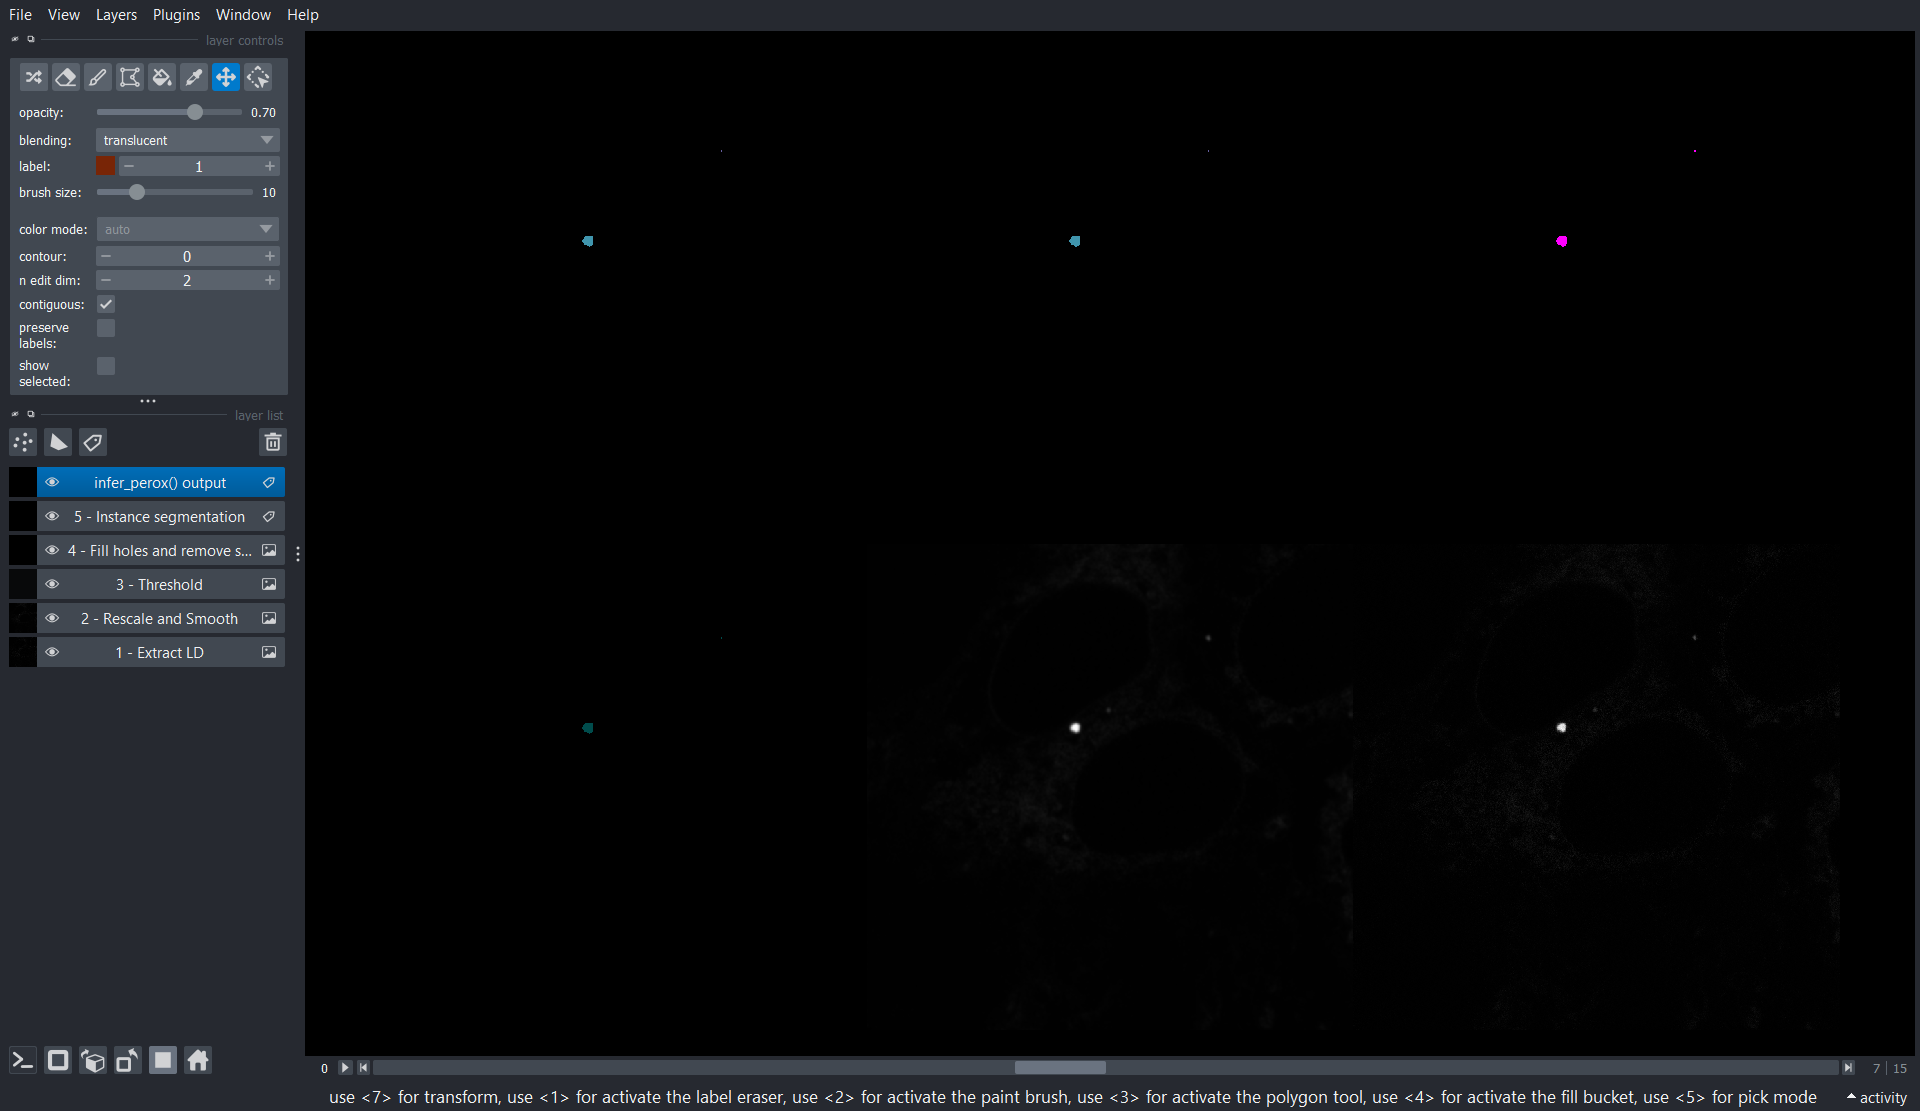

In [ ]:
_LD_obj =  _infer_LD(
        img_data,
        LD_CH,  
        med_filter_size, 
        gaussian_smoothing_sigma, 
        method, 
        threshold_factor, 
        thresh_min, 
        thresh_max, 
        hole_min_width,
        hole_max_width, 
        small_object_width,
        fill_filter_method) 

#confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(LD_labels == _LD_obj)}")

# adding image to Napari as a new layer
viewer.add_labels(_LD_obj, scale=scale, name="infer_perox() output")
viewer.grid.enabled = True
viewer.reset_view()

# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

-------------
### ✅ **INFER LIPID DROPLETS COMPLETE!**

Continue on to other notebooks as needed:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)

Or proceed to batch processing here: [batch process notebook](batch_process_segmentations.ipynb)